## Nilearn simple NN
A simple neural net that trains itself on a single fMRI, and predicts... something.

In [1]:
## Nilearn tests
# Following http://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#sphx-glr-auto-examples-plot-decoding-tutorial-py
%matplotlib inline
import nilearn
from nilearn import datasets, plotting
from nilearn.input_data import NiftiMasker
import numpy as np
import nibabel

## Get the data, and show a demo visualization

In [2]:
haxby_dataset = datasets.fetch_haxby(subjects=list(range(1, 7)))

fmri = nilearn.image.load_img(haxby_dataset.func[1])
dataobj = fmri.get_data()

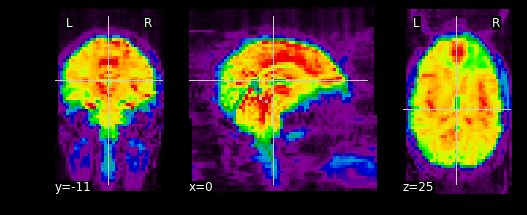

In [3]:
# Get image at a particular time, formatted for the CNN
def getImage(data, i):
    return data[:,:,:,i].reshape(1,40,64,64)

# Display an image/tensor that is stored as the input to the CNN
def displayImage(image, affine=fmri.affine):
    nilearn.plotting.plot_epi(nibabel.Nifti1Image(image.reshape(40,64,64), affine))

# Make a stupid list of 2 tensors and dummy data.
images = np.array([getImage(dataobj, 0), getImage(dataobj, 1)])

displayImage(images[0])

X_train = images
Y_train = [[1,0], [0,1]]
X_test = X_train
Y_test = Y_train


input_shape = (1, 40, 64, 64)
output_shape = (2) # Kinda silly - not actually used by the NN

# Setup the Deep NN

In [4]:
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.utils import np_utils
K.set_image_dim_ordering('th')



Using Theano backend.


In [5]:
model = Sequential()

# Convolution2D(number_filters, row_size, column_size, input_shape=(number_channels, img_row, img_col))

model.add(Convolution3D(6, 2, 5, 5, input_shape=input_shape, border_mode='same', name='conv2d_1'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), name='maxpool_1'))
model.add(Convolution3D(16, 2, 5, 5, border_mode='same', name='conv2d_2'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), name='maxpool_2'))
model.add(Convolution3D(120, 2, 5, 5, name='conv2d_3'))
model.add(Activation('relu'))
#model.add(Dropout(0.25, name='dropout_2'))
shape = model.layers[-1].output_shape
model.add(Reshape((shape[1]*shape[2]*shape[3]*shape[4],)))
model.add(Dense(2, name='dense_squirrel'))

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta')
nb_epoch = 2  # try increasing this number
batch_size = 2
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)

/Users/ezradavis/anaconda3/lib/python3.5/site-packages/keras/models.py:603: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 2 samples, validate on 2 samples
Epoch 1/2
2/2 [==============================] - 0s - loss: 0.6830 - val_loss: 8.0590
Epoch 2/2
2/2 [==============================] - 0s - loss: 8.0590 - val_loss: 8.0590


/Users/ezradavis/anaconda3/lib/python3.5/site-packages/keras/models.py:644: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


### Perform a max patch visualization

In [7]:
# Code has been moved below hacked max_patch modification

In [16]:
## Multipurpose max patch functions

import numpy as np
from keras import backend as K
import keras

convolutional_classes = (
    keras.layers.Convolution2D,
    keras.layers.Convolution3D,
    keras.layers.convolutional.ZeroPadding2D,
    keras.layers.convolutional.ZeroPadding3D
)

# Works only for 2D images
def patch_from_location(image, max_location, patch_size, outputs):
    print(max_location)
    x = int(max_location[1]/outputs[0].shape[-1]*image.shape[1])
    y = int(max_location[0]/outputs[0].shape[-2]*image.shape[0])
    top = np.clip(y-patch_size[0]//2,    0, image.shape[0])
    left = np.clip(x-patch_size[1]//2,   0, image.shape[1])
    return image[top:np.clip(top+patch_size[0], 0, image.shape[0]),
                 left:np.clip(left+patch_size[1], 0, image.shape[1])]

# Gets a patch from a location (array with values from 0-1, and a particular image)
def new_patch_from_location(image_index, max_location, images):
    print(images[0].shape)
    percent = 10/100 # Create an patch that is 10% of the original image
    image = images[image_index]
    shape = image.shape
    #TODO make next line sane
    max_location = np.array([1,1] + list(max_location)) # Momentary hack
    if(len(shape) != len(max_location)):
        print("Image shape ({:}) doesn't match max_location length ({:})".format(shape, len(max_location)))
    mins = np.floor(np.multiply(max_location-percent/2,shape)).astype(int)
    maxes = np.floor(np.multiply(max_location+percent/2,shape)).astype(int)
    patch_area = [range(mini,maxi)for mini,maxi in zip(mins, maxes)]
    patch = np.zeros(shape=shape) # Create an empty array to put the patch in
    
    def isolate_area(image_view, patch_view, patch_area):
        if(len(patch_area) == 1):
            for i in patch_area[0]:
                patch_view[i] = image_view[i]
        else:
            for i in patch_area[0]:
                isolate_area(image_view[i], patch_view[i], patch_area[1:])
    
    isolate_area(image, patch, patch_area)
    
    return patch

  

# Tested/built for Theano... should be tensorflow compatible
def max_patch(model, data, images=None, layer=None, layer_number=-1, filter_number=0, number_of_patches=9, patch_size=(8,8), patch_from_location=patch_from_location):
    
    # images are unpreprocessed data
    if images == None:
        images = data
    
    # Layer is an optional argument
    if layer == None:
        layer = model.layers[layer_number]
    
    # Make sure the layer is a convolutional layer
    if not isinstance(layer, convolutional_classes):
        print('Hey! Your layer is of class {:}. Are you sure you want to get a 2D max patch of it?'.format(layer.__class__))
    
    if (images[0].shape[-1] > layer.output_shape[-1] * patch_size[-1] or
        images[0].shape[-2] > layer.output_shape[-2] * patch_size[-2]):
        print('Hey! Your patch size is small for this layer\'s output relative to the original image. You might want to increase it.')

    # Has shape (1), where each element is the layer's output.
    # A typical layer's output is (1, filters, width, height)
    get_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [layer.output])
    
    # List of np.arrays(shape=(width, height))
    #o = get_layer_output([data[0], 0])
    #print(o)
    outputs = [get_layer_output([inputs, 0])[0][0][filter_number] for inputs in data]
    
    # Get the maximum values
    maxes = [output.argmax() for output in outputs]
    
    # The indices of the images with the n highest maxes
    image_indices = np.argsort(maxes)[:number_of_patches]
    
    max_outputs = [ outputs[index] for index in image_indices]
    
    # Maximum locations in each 'image'
    # list of (x, y) locations... (technically, (x,y,z,q) locations are fine too)
    max_locations = [np.unravel_index(output.argmax(), output.shape) for output in max_outputs]

    #print("max_outputs[0].shape " + str(max_outputs[0].shape))
    #print("max_location[0] ", str(max_locations[0]))
    
    #print('max_locations', max_locations)
    # Works for multidimensional input
    # Get the location of the centers as fractions (between 0 and 1)
    # List of (index, (x,y)) where 0 < x < 1
    
    #patches = [patch_from_location(images[image_indices[index]], max_locations[index], patch_size, outputs=outputs)
    #        for index in range(len(image_indices))]
    
    # New version works for N dimensions, and zeros out the rest of the 'image'
    patches = [new_patch_from_location(image_indices[index], np.array(max_locations[index])/np.array(max_outputs[0].shape), images)
              for index in range(len(image_indices))]
        
    return patches


If you're not Ezra, make sure that the notebook path is appropriate. Sadly __file__ does not exist for ipynb
max_outputs[0].shape (40, 64, 64)
max_location[0]  (21, 25, 33)
(1, 1, 40, 64, 64)


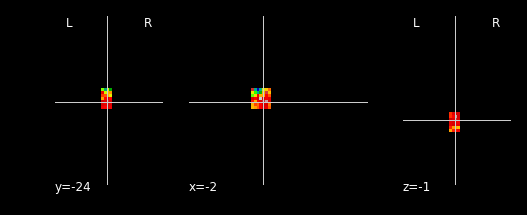

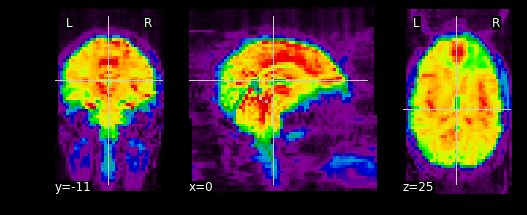

In [18]:
import max_patch as mp

notebook_path = "/Users/ezradavis/Desktop/Ezra's_Folder/school/WPI/Fourth Year/mqp/mqpproject"
print('If you\'re not Ezra, make sure that the notebook path is appropriate. Sadly __file__ does not exist for ipynb')
def load_src(name, fpath):
    import os, imp
    return imp.load_source(name, os.path.join(notebook_path, fpath))

load_src("mp", "max_patch.py")

layers = mp.get_convolutional_layers(model)

patches = max_patch(model, [np.array([images[0]])], layer=layers[0])
displayImage(patches[0])
displayImage(images[0])